In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from tensorflow.python.keras.backend import set_session
from tensorflow.keras import layers, Model

import os
import random
import numpy as np

from tqdm import tqdm

from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
## Variaveis
seeds = [13, 42, 1,83,76]
np.random.seed(0)
num_classes = 1
split_size = 0.2
k = 5
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
NUM_TEST_IMAGES = 10


# Definindo o caminho da pasta
imagens = '/content/drive/MyDrive/Mestrado/Imagens1'
mascara = '/content/drive/MyDrive/Mestrado/mascaras1'

# Listando todos os arquivos na pasta
imagens_lista = os.listdir(imagens)
mascaras_lista = os.listdir(mascara)

# Inicializando listas para cada coluna
imagens_id = []
mascara_id = []


In [4]:
# Loop pelos arquivos e preenchendo as listas com informações da pasta de imagens:
for arquivo in imagens_lista:
    # Nome e extensão do arquivo
    imagens_id.append(arquivo)

# Criando o DataFrame das imagens
df_img = pd.DataFrame({
    'Imagens_id': imagens_id
})

# Loop pelos arquivos e preenchendo as listas com informações da pasta de mascaras:
for arquivo in mascaras_lista:
    # Nome e extensão do arquivo
    mascara_id.append(arquivo)

# Criando o DataFrame das mascaras
df_msk = pd.DataFrame({
    'mascaras_id': mascara_id
})

In [5]:
print(df_img.head(10))
print(df_img.shape)

print(df_msk.head(10))
print(df_msk.shape)

                          Imagens_id
0  SIMCEPImages_A02_C5_F1_s01_w2.TIF
1  SIMCEPImages_A02_C5_F1_s01_w1.TIF
2  SIMCEPImages_A02_C5_F1_s02_w1.TIF
3  SIMCEPImages_A02_C5_F1_s02_w2.TIF
4  SIMCEPImages_A02_C5_F1_s03_w1.TIF
5  SIMCEPImages_A02_C5_F1_s03_w2.TIF
6  SIMCEPImages_A02_C5_F1_s04_w1.TIF
7  SIMCEPImages_A02_C5_F1_s04_w2.TIF
8  SIMCEPImages_A02_C5_F1_s05_w2.TIF
9  SIMCEPImages_A02_C5_F1_s05_w1.TIF
(100, 1)
                         mascaras_id
0  SIMCEPImages_A02_C5_F1_s01_w2.TIF
1  SIMCEPImages_A02_C5_F1_s01_w1.TIF
2  SIMCEPImages_A02_C5_F1_s02_w1.TIF
3  SIMCEPImages_A02_C5_F1_s02_w2.TIF
4  SIMCEPImages_A02_C5_F1_s03_w1.TIF
5  SIMCEPImages_A02_C5_F1_s03_w2.TIF
6  SIMCEPImages_A02_C5_F1_s04_w1.TIF
7  SIMCEPImages_A02_C5_F1_s04_w2.TIF
8  SIMCEPImages_A02_C5_F1_s05_w2.TIF
9  SIMCEPImages_A02_C5_F1_s05_w1.TIF
(100, 1)


In [6]:
# Get lists of images and their masks.

image_id_list = list(df_img['Imagens_id'])
mask_id_list = list(df_msk['mascaras_id'])

# Create empty arrays

X = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

y = np.zeros((len(mask_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [7]:
# X imagens

for i, imagens_id in enumerate(image_id_list):

    path_image = '/content/drive/MyDrive/Mestrado/Imagens1/' + imagens_id

    # read the image using skimage
    image = imread(path_image)

    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)

    # insert the image into X_train
    X[i] = image

print(X.shape)

(100, 128, 128, 1)


In [8]:
# Y classes (mascras)


for i, mascara_id in enumerate(mask_id_list):

    path_mask = '/content/drive/MyDrive/Mestrado/mascaras1/' + mascara_id

    # read the image using skimage
    mask = imread(path_mask)
    mask = (mask >= 250)

    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)

    # insert the image into Y_Train
    y[i] = mask

print(y.shape)

(100, 128, 128, 1)


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


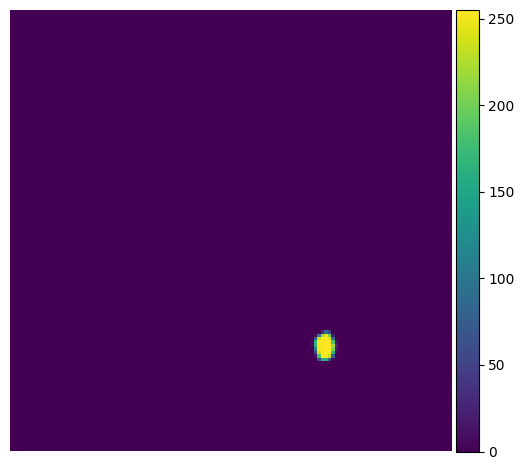

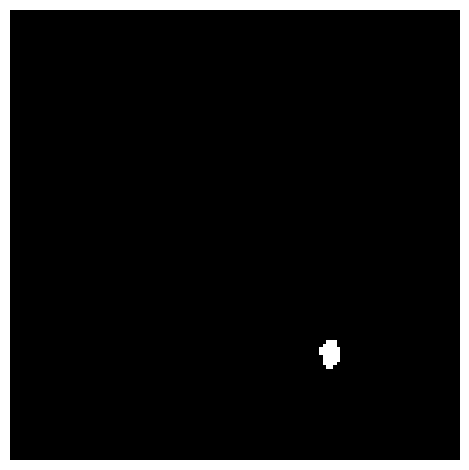

In [9]:
# Sample image and Ground-Truth Label from dataset

image_x = random.randint(0, len(X))
plt.axis("off")
imshow(X[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y[image_x]))
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Add, Lambda, Input, Activation, BatchNormalization, concatenate


def resunet():

      def residual_block(inputs, filters, kernel_size=(3, 3), activation='elu'):
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)

        # Conexão Residual
        shortcut = Conv2D(filters, (1, 1), padding='same')(inputs)
        x = Add()([x, shortcut])
        x = Activation(activation)(x)
        return x

      inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
      s = Lambda(lambda x: x / 255)(inputs)

      # Encoder com blocos residuais
      c1 = residual_block(s, 16)
      p1 = MaxPooling2D((2, 2))(c1)
      p1 = Dropout(0.1)(p1)

      c2 = residual_block(p1, 32)
      p2 = MaxPooling2D((2, 2))(c2)
      p2 = Dropout(0.1)(p2)

      c3 = residual_block(p2, 64)
      p3 = MaxPooling2D((2, 2))(c3)
      p3 = Dropout(0.2)(p3)

      c4 = residual_block(p3, 128)
      p4 = MaxPooling2D((2, 2))(c4)
      p4 = Dropout(0.2)(p4)

      # Bottleneck com bloco residual
      c5 = residual_block(p4, 256)
      c5 = Dropout(0.3)(c5)

      # Decoder com blocos residuais
      u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
      u6 = concatenate([u6, c4])
      c6 = residual_block(u6, 128)
      c6 = Dropout(0.2)(c6)

      u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
      u7 = concatenate([u7, c3])
      c7 = residual_block(u7, 64)
      c7 = Dropout(0.2)(c7)

      u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
      u8 = concatenate([u8, c2])
      c8 = residual_block(u8, 32)
      c8 = Dropout(0.1)(c8)

      u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
      u9 = concatenate([u9, c1])
      c9 = residual_block(u9, 16)
      c9 = Dropout(0.1)(c9)

      # Camada de saída
      outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

      model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

      model.summary()

      return model


In [30]:
acc = []
jacc = []
f1 = []
prec = []
rec = []


for f in range(1, len(seeds)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size, random_state=seeds[f])


    model = resunet()

    checkpoint_filepath = 'model1_' + str(f+1)+'fold.keras'
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_recall',
                mode='max',
                save_best_only=True,
                verbose=1)]

    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=5, callbacks=callbacks)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()

        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    del model


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6830 - loss: 0.6607 - recall: 0.3328
Epoch 1: val_recall improved from -inf to 0.80153, saving model to model1_2fold.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.7011 - loss: 0.6443 - recall: 0.3606 - val_accuracy: 0.5191 - val_loss: 0.7044 - val_recall: 0.8015
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9683 - loss: 0.2884 - recall: 0.8303
Epoch 2: val_recall did not improve from 0.80153
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9694 - loss: 0.2782 - recall: 0.8302 - val_accuracy: 0.7186 - val_loss: 0.6664 - val_recall: 0.2093
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9893 - loss: 0.0632 - recall: 0.5996
Epoch 3: val_recall did not improve from 0.80153
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9893 - loss: 0.0621 - recall: 0.5895 - val_accuracy: 0.8601 - val_loss: 0.4054 - val_recall: 0.2360
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9915 - loss: 0.0291 - 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 128, 128, 1)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_112 (Conv2D)       │ (None, 128, 128, 16)   │            160 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 128, 128, 16)   │             64 │ conv2d_112[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 128, 128, 16)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 128, 128, 16)   │             64 │ conv2d_113[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 128, 128, 16)   │             32 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_36 (Add)              │ (None, 128, 128, 16)   │              0 │ batch_normalization_7… │
│                           │                        │                │ conv2d_114[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 128, 128, 16)   │              0 │ add_36[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 16)     │              0 │ activation_73[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 64, 64, 16)     │              0 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 64, 64, 32)     │          4,640 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 64, 64, 32)     │            128 │ conv2d_115[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 64, 64, 32)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 2,034,497 (7.76 MB)

 Trainable params: 2,031,553 (7.75 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6031 - loss: 0.7483 - recall: 0.7403
Epoch 1: val_recall improved from -inf to 0.90314, saving model to model1_3fold.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6261 - loss: 0.7327 - recall: 0.7567 - val_accuracy: 0.7485 - val_loss: 0.7094 - val_recall: 0.9031
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9572 - loss: 0.3733 - recall: 0.9090
Epoch 2: val_recall did not improve from 0.90314
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9589 - loss: 0.3623 - recall: 0.9061 - val_accuracy: 0.7981 - val_loss: 0.7681 - val_recall: 0.8225
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9872 - loss: 0.1082 - recall: 0.6208
Epoch 3: val_recall did not improve from 0.90314
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9871 - loss: 0.1063 - recall: 0.6019 - val_accuracy: 0.8604 - val_loss: 0.5480 - val_recall: 0.8799
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9895 - loss:

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 128, 128, 1)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 128, 128, 16)   │            160 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 128, 128, 16)   │             64 │ conv2d_140[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_90             │ (None, 128, 128, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_141 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ activation_90[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 128, 128, 16)   │             64 │ conv2d_141[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 128, 128, 16)   │             32 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_45 (Add)              │ (None, 128, 128, 16)   │              0 │ batch_normalization_9… │
│                           │                        │                │ conv2d_142[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_91             │ (None, 128, 128, 16)   │              0 │ add_45[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 64, 64, 16)     │              0 │ activation_91[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_45 (Dropout)      │ (None, 64, 64, 16)     │              0 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_143 (Conv2D)       │ (None, 64, 64, 32)     │          4,640 │ dropout_45[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 64, 64, 32)     │            128 │ conv2d_143[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_92             │ (None, 64, 64, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 2,034,497 (7.76 MB)

 Trainable params: 2,031,553 (7.75 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5965 - loss: 0.8461 - recall: 0.8118
Epoch 1: val_recall improved from -inf to 0.94259, saving model to model1_4fold.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6188 - loss: 0.8270 - recall: 0.8217 - val_accuracy: 0.7374 - val_loss: 0.7110 - val_recall: 0.9426
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9558 - loss: 0.4026 - recall: 0.9161
Epoch 2: val_recall did not improve from 0.94259
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.9576 - loss: 0.3916 - recall: 0.9036 - val_accuracy: 0.8980 - val_loss: 0.4734 - val_recall: 0.2533
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9864 - loss: 0.1339 - recall: 0.6496
Epoch 3: val_recall did not improve from 0.94259
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9865 - loss: 0.1295 - recall: 0.6451 - val_accuracy: 0.9524 - val_loss: 0.3810 - val_recall: 0.3264
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9895 - loss:

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 128, 128, 1)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_168 (Conv2D)       │ (None, 128, 128, 16)   │            160 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_108   │ (None, 128, 128, 16)   │             64 │ conv2d_168[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_108            │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_169 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ activation_108[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 128, 128, 16)   │             64 │ conv2d_169[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_170 (Conv2D)       │ (None, 128, 128, 16)   │             32 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_54 (Add)              │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_170[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_109            │ (None, 128, 128, 16)   │              0 │ add_54[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 64, 64, 16)     │              0 │ activation_109[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 64, 64, 16)     │              0 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_171 (Conv2D)       │ (None, 64, 64, 32)     │          4,640 │ dropout_54[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 64, 64, 32)     │            128 │ conv2d_171[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_110            │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 2,034,497 (7.76 MB)

 Trainable params: 2,031,553 (7.75 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6801 - loss: 0.6716 - recall: 0.8220
Epoch 1: val_recall improved from -inf to 0.75454, saving model to model1_5fold.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6972 - loss: 0.6604 - recall: 0.8317 - val_accuracy: 0.6632 - val_loss: 0.7483 - val_recall: 0.7545
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9589 - loss: 0.3753 - recall: 0.9112
Epoch 2: val_recall did not improve from 0.75454
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9603 - loss: 0.3666 - recall: 0.9152 - val_accuracy: 0.8324 - val_loss: 0.8996 - val_recall: 0.2873
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9876 - loss: 0.1281 - recall: 0.7831
Epoch 3: val_recall did not improve from 0.75454
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9877 - loss: 0.1234 - recall: 0.7694 - val_accuracy: 0.8520 - val_loss: 0.7306 - val_recall: 0.1352
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9924 - loss: